In [1]:
%%capture
# Install facenet-pytorch
!pip install /home/sukanya/deepfake/facenet-pytorch-vggface2/facenet_pytorch-1.0.1-py3-none-any.whl
# Copy model checkpoints to torch cache so they are loaded automatically by the package
!mkdir -p /tmp/.cache/torch/checkpoints/
!cp /home/sukanya/deepfake/facenet-pytorch-vggface2/20180402-114759-vggface2-logits.pth /tmp/.cache/torch/checkpoints/vggface2_DG3kwML46X.pt
!cp /home/sukanya/deepfake/facenet-pytorch-vggface2/20180402-114759-vggface2-features.pth /tmp/.cache/torch/checkpoints/vggface2_G5aNV2VSMn.pt

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import gc
import cv2
import glob
import time
import copy
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
from facenet_pytorch import MTCNN, InceptionResnetV1

In [3]:
import sys
package_path = '/home/sukanya/deepfake/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master'
sys.path.append(package_path)

from efficientnet_pytorch import EfficientNet

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
seed_everything(0)

In [6]:
# Set Trained Weight Path
weight_path = 'efficientnet_b0_epoch_15_loss_0.158.pth'
trained_weights_path = os.path.join('/home/sukanya/deepfake/deepfake-detection-model-weight', weight_path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark=True

In [7]:
test_dir = '/home/sukanya/deepfake/deepfake-detection-challenge/test_videos'
os.listdir(test_dir)[:5]

['qooxnxqqjb.mp4',
 'hierggamuo.mp4',
 'ocgdbrgmtq.mp4',
 'icbsahlivv.mp4',
 'prhmixykhr.mp4']

In [8]:
def get_img_from_mov(video_file, num_img, frame_window):
    cap = cv2.VideoCapture(video_file)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    image_list = []
    for i in range(num_img):
        _, image = cap.read()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_list.append(image)
        cap.set(cv2.CAP_PROP_POS_FRAMES, (i + 1) * frame_window)
        if cap.get(cv2.CAP_PROP_POS_FRAMES) >= frames:
            break
    cap.release()

    return image_list

In [9]:
class ImageTransform:
    def __init__(self, size, mean, std):
        self.data_transform = transforms.Compose([
                transforms.Resize((size, size), interpolation=Image.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

    def __call__(self, img):
        return self.data_transform(img)

In [10]:
class DeepfakeDataset(Dataset):
    def __init__(self, file_list, device, detector, transform, img_num=20, frame_window=10):
        self.file_list = file_list
        self.device = device
        self.detector = detector
        self.transform = transform
        self.img_num = img_num
        self.frame_window = frame_window

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):

        mov_path = self.file_list[idx]
        img_list = []

        # Movie to Image
        try:
            all_image = get_img_from_mov(mov_path, self.img_num, self.frame_window)
        except:
            return [], mov_path.split('/')[-1]
        
        # Detect Faces
        for image in all_image:
            
            try:
                _image = image[np.newaxis, :, :, :]
                boxes, probs = self.detector.detect(_image, landmarks=False)
                x = int(boxes[0][0][0])
                y = int(boxes[0][0][1])
                z = int(boxes[0][0][2])
                w = int(boxes[0][0][3])
                image = image[y-15:w+15, x-15:z+15]
                
                # Preprocessing
                image = Image.fromarray(image)
                image = self.transform(image)
                
                img_list.append(image)

            except:
                img_list.append(None)
            
        # Padding None
        img_list = [c for c in img_list if c is not None]
        
        return img_list, mov_path.split('/')[-1]

In [11]:
model = EfficientNet.from_name('efficientnet-b0')
model._fc = nn.Linear(in_features=model._fc.in_features, out_features=1)
model.load_state_dict(torch.load(trained_weights_path, map_location=torch.device(device)))

<All keys matched successfully>

In [12]:
test_file = [os.path.join(test_dir, path) for path in os.listdir(test_dir)]

In [14]:
# Prediction
def predict_dfdc(dataset, model):
    
    torch.cuda.empty_cache()
    pred_list = []
    path_list = []
    
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for i in tqdm(range(len(dataset))):
            pred = 0
            imgs, mov_path = dataset.__getitem__(i)
            
            # No get Image
            if len(imgs) == 0:
                pred_list.append(0.5)
                path_list.append(mov_path)
                continue
                
                
            for i in range(len(imgs)):
                img = imgs[i]
                
                output = model(img.unsqueeze(0).to(device))
                pred += torch.sigmoid(output).item() / len(imgs)
                
            pred_list.append(pred)
            path_list.append(mov_path)
            
    torch.cuda.empty_cache()
            
    return path_list, pred_list

In [15]:
# Config
img_size = 120
img_num = 15
frame_window = 5
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(img_size, mean, std)

detector = MTCNN(image_size=img_size, margin=14, keep_all=False, factor=0.5, 
                 select_largest=False, post_process=False, device=device).eval()

dataset = DeepfakeDataset(test_file, device, detector, transform, img_num, frame_window)

path_list, pred_list = predict_dfdc(dataset, model)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [16]:
res = pd.DataFrame({
    'filename': path_list,
    'label': pred_list,
})

res.sort_values(by='filename', ascending=True, inplace=True)

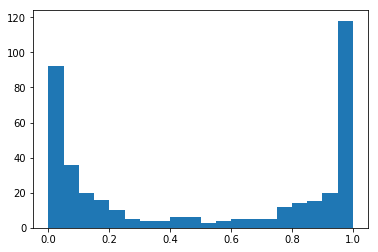

In [17]:
plt.hist(res['label'], 20)
plt.show()

In [18]:
res.head(10)

,filename,label
281,aassnaulhq.mp4,0.980907
185,aayfryxljh.mp4,0.000571
322,acazlolrpz.mp4,0.863356
377,adohdulfwb.mp4,0.027974
174,ahjnxtiamx.mp4,0.713677
135,ajiyrjfyzp.mp4,0.597599
218,aktnlyqpah.mp4,0.999882
196,alrtntfxtd.mp4,0.892700
244,aomqqjipcp.mp4,0.996379
21,apedduehoy.mp4,0.022171
